<h4> Импорт библиотек </h4>

In [8]:
import os
import pandas as pd
import re
import pymorphy2
from statistics import mean
import math
import string
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
morph = pymorphy2.MorphAnalyzer()

<h4> Загрузка частотного словаря </h4> 

In [81]:
try:
    all_freq = pd.read_csv('freqrnc2011.csv', sep='\t')
except FileNotFoundError:
    raise Exception("Файл частотного словаря 'freqrnc2011.csv' не найден в рабочей директории")

<h4> Функции предобработки текста: </h4>

In [2]:
def read_text_file(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        with open(filename, 'r', encoding='cp1251') as file:
            return file.read()

<i> 1. Очистка текста от метаданных CHAT формата</i>

In [4]:
def clean_cha_text(text):
    return '\n'.join(line for line in text.split('\n') if not line.startswith('*INV:'))

<i> 2. Удаление пунктуации </i>

In [11]:
def remove_punctuation(word):
    rus_punctuation = '«»—'
    all_punctuation = string.punctuation + rus_punctuation
    return word.translate(str.maketrans('', '', all_punctuation))

<i> 3. Лемматизация текста </i>

In [5]:
def lemmatize_text(text):
    """
    Лемматизация текста с извлечением русских слов
    Возвращает:
        - lemmatized: список лемматизированных слов
        - all_words: список всех слов (без лемматизации)
    """
    cleaned_text = clean_cha_text(text)
    par_lines = re.findall(r'\*PAR:\t[A-zА-я\+\s&\-\*\[\]\<:\>/\(\)\.=x%\d?!]+\s+', cleaned_text)
    
    all_words = []
    lemmatized = []
    
    for line in par_lines:
        words = re.findall(r'[А-я\-]+', line)
        cleaned_words = [remove_punctuation(w) for w in words if remove_punctuation(w)]
        all_words.extend(cleaned_words)
    
    for word in all_words:
        try:
            lemmatized.append(morph.parse(word)[0].normal_form)
        except:
            continue
            
    return lemmatized, all_words

<h4> Функции для подсчета лексических параметров: </h4>

<i>1. Подсчет частей речи </i>

In [86]:
def count_pos(words, pos_tag):
    if pos_tag == 'VERB':
        return sum(1 for w in words if morph.parse(w)[0].tag.POS in {pos_tag, 'INFN'})
    else:
        return sum(1 for w in words if morph.parse(w)[0].tag.POS in {pos_tag})

<i>2. Расчет соотношений между частями речи </i>

In [87]:
def calculate_ratios(pronouns, verbs, nouns, total_words):
    metrics = {
        'pronouns': pronouns,
        'verbs': verbs,
        'nouns': nouns,
        'percent_pronouns': pronouns / total_words if total_words > 0 else 0,
        'percent_verbs': verbs / total_words if total_words > 0 else 0,
        'percent_nouns': nouns / total_words if total_words > 0 else 0,
        'pronoun_noun_ratio': pronouns / nouns if nouns > 0 else 0,
        'verbs_noun_ratio': verbs / nouns if nouns > 0 else 0
    }
    return metrics

<i>3. Подсчет частотных слов </i>

In [88]:
def calculate_frequency_metrics(lemmatized):
    freq_dict = {}
    for word in lemmatized:
        if word in all_freq['Lemma'].values:
            freq = all_freq.loc[all_freq['Lemma'] == word, 'Freq(ipm)'].values[0]
            freq_dict[word] = freq
    
    log_freqs = [math.log(freq) for freq in freq_dict.values()] if freq_dict else [0]
    return {'mean_log_freq': mean(log_freqs)}

<h4>Основные функции обработки файлов:</h4>

In [106]:
def process_cha_file(filepath):
    text = read_text_file(filepath)
    lemmatized, all_words = lemmatize_text(text)
    total_words = len(lemmatized)
    
    if total_words == 0:
        return None
    
    # Подсчет частей речи
    pronouns = count_pos(lemmatized, 'NPRO')
    verbs = count_pos(lemmatized, 'VERB')
    nouns = count_pos(lemmatized, 'NOUN')
    
    # Вычисление метрик
    metrics = {
        'filename': os.path.basename(filepath),
        'total_words': total_words,
        **calculate_ratios(pronouns, verbs, nouns, total_words),
        **calculate_frequency_metrics(lemmatized)
    }
    
    return metrics

In [90]:
def analyze_group(folder_path, group_name):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Папка не найдена: {folder_path}")
    
    results = []
    processed_files = 0
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.cha'):
            filepath = os.path.join(folder_path, filename)
            try:
                metrics = process_cha_file(filepath)
                if metrics:
                    results.append(metrics)
                    processed_files += 1
                    print(f"Обработан файл: {filename}")
            except Exception as e:
                print(f"Ошибка при обработке {filename}: {str(e)}")
    
    if not results:
        print(f"Внимание: в папке {folder_path} не найдено подходящих .cha файлов")
        return pd.DataFrame()
    
    df = pd.DataFrame(results)
    df['group'] = group_name
    print(f"\nОбработано файлов: {processed_files}")
    return df

<h4> Статистический анализ: </h4>

<i>1. Проверка нормальности распределения </i>

In [91]:
def check_normality(df, columns):
    print("\n=== Проверка нормальности распределения ===")
    normality_results = {}
    
    for col in columns:
        stat, p = shapiro(df[col])
        normality_results[col] = p > 0.05
        print(f"{col}: {'Нормальное' if p > 0.05 else 'Не нормальное'} (p={p:.4f})")
    
    return normality_results

<i>2. Сравнение групп с автоматическим выбором теста:
    
- t-тест для нормальных распределений
    
- U-тест Манна-Уитни для ненормальных распределений</i>

In [92]:
def compare_groups(df_mci, df_control, columns):
    normality_mci = check_normality(df_mci, columns)
    normality_control = check_normality(df_control, columns)
    
    print("\n=== Результаты сравнения групп ===")
    results = []
    for col in columns:
        # Выбор теста в зависимости от нормальности распределения
        if normality_mci[col] and normality_control[col]:
            # Параметрический t-тест
            t_stat, p_val = ttest_ind(df_mci[col], df_control[col])
            test_type = "t-тест"
            results.append((col, test_type, t_stat, p_val))
        else:
            # Непараметрический U-тест
            u_stat, p_val = mannwhitneyu(df_mci[col], df_control[col])
            test_type = "U-тест"
            results.append((col, test_type, u_stat, p_val))
    
    print("\n{:<25} {:<10} {:<15} {:<10}".format(
        "Параметр", "Тест", "Статистика", "p-value"))
    print("-" * 60)
    for res in results:
        print("{:<25} {:<10} {:<15.3f} {:<10.4f}".format(*res))
    
    return results

<i>3. Расширенный ANOVA анализ с проверкой предположений</i>

In [125]:
def compute_eta_squared(anova_stat, df_between, df_within):
    """Расчет эффекта размера Eta-squared для ANOVA."""
    return anova_stat * df_between / (anova_stat * df_between + df_within)

def improved_anova_analysis(df_combined, columns_to_analyze):
    print("\n=== Улучшенный дисперсионный анализ (ANOVA) ===")

    anova_results = []

    for col in columns_to_analyze:
        group_mci = df_combined[df_combined['group'] == 'MCI'][col]
        group_control = df_combined[df_combined['group'] == 'control'][col]

        # Проверка нормальности
        _, p_mci = shapiro(group_mci)
        _, p_control = shapiro(group_control)

        # Проверка гомогенности дисперсий
        _, p_levene = levene(group_mci, group_control)

        if p_mci > 0.05 and p_control > 0.05 and p_levene > 0.05:
            # ANOVA
            f_val, p_val = f_oneway(group_mci, group_control)
            test_type = "ANOVA"
            df_between = 1
            df_within = len(group_mci) + len(group_control) - 2
            effect_size = compute_eta_squared(f_val, df_between, df_within)
        else:
            # Kruskal-Wallis
            h_val, p_val = kruskal(group_mci, group_control)
            test_type = "Kruskal-Wallis"
            f_val = h_val
            effect_size = None  # Для Kruskal не считается Eta-squared

        anova_results.append({
            'Parameter': col,
            'Test': test_type,
            'Statistic': f_val,
            'p-value': p_val,
            'Significant': p_val < 0.05,
            'Effect Size (eta²)': effect_size
        })

    results_df = pd.DataFrame(anova_results)

    # Визуализация
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='Parameter',
        y='Statistic',
        hue='Significant',
        data=results_df,
        palette={True: 'red', False: 'blue'}
    )

    for i, row in results_df.iterrows():
        ax.text(i, row['Statistic'] + 0.1, f"p={row['p-value']:.3f}", ha='center')

    plt.title('Результаты дисперсионного анализа')
    plt.xticks(rotation=45)
    plt.ylabel('F / H статистика')
    plt.xlabel('Параметры')
    plt.legend(title='Значимость (p<0.05)')
    plt.tight_layout()
    plt.show()

    print("\nРезультаты дисперсионного анализа с размером эффекта:")
    print(results_df.to_string(index=False))

    return results_df


<h4> Визуализация результатов: </h4>

<i> 1. Построение boxplot и swarmplot </i>

<i> 2. Q-Q графики для проверки нормальности </i>

In [136]:
def plot_selected_results(df, columns, save_dir="plots"):
    print("\nПостроение графиков для выбранных параметров")
    
    # Создаем папку, если её нет
    os.makedirs(save_dir, exist_ok=True)
    
    # Фильтруем только нужные колонки
    selected_columns = [
        'percent_pronouns', 'percent_nouns', 'percent_verbs',
        'verbs_noun_ratio', 'pronoun_noun_ratio', 'mean_log_freq'
    ]
    
    for col in selected_columns:
        if col in columns:
            # --- Boxplot + Swarmplot ---
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='group', y=col, data=df)
            sns.swarmplot(x='group', y=col, data=df, color='black', alpha=0.5)
            plt.title(f'Распределение {col} по группам')
            plt.tight_layout()
            
            # Сохраняем график
            boxplot_path = os.path.join(save_dir, f"boxplot_{col}.png")
            plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()
            
            # --- Q-Q Plot ---
            plt.figure(figsize=(12, 5))
            
            # Q-Q plot для MCI
            plt.subplot(1, 2, 1)
            qqplot(df[df['group'] == 'MCI'][col], line='s', ax=plt.gca())
            plt.title(f'MCI: Q-Q plot для {col}')
            
            # Q-Q plot для control
            plt.subplot(1, 2, 2)
            qqplot(df[df['group'] == 'control'][col], line='s', ax=plt.gca())
            plt.title(f'Control: Q-Q plot для {col}')
            plt.tight_layout()
            
            # Сохраняем график
            qqplot_path = os.path.join(save_dir, f"qqplot_{col}.png")
            plt.savefig(qqplot_path, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

<h4> Основной рабочий процесс: </h4>
<i> Функция run_analysis объединяет все этапы анализа </i>

In [137]:
def run_analysis(mci_folder, control_folder, group_size):
    print(f"\n{'='*50}")
    print(f"Начало анализа для группы из {group_size} человек")
    print(f"{'='*50}\n")
    
    # 1. Обработка данных
    print("=== Обработка группы MCI ===")
    df_mci = analyze_group(mci_folder, 'MCI')
    df_mci.to_csv(f'mci_results_{group_size}.csv', index=False)  # Сохраняем результаты MCI
    
    print("\n=== Обработка контрольной группы ===")
    df_control = analyze_group(control_folder, 'control')
    df_control.to_csv(f'control_results_{group_size}.csv', index=False)  # Сохраняем результаты control
    
    # 2. Объединение данных
    df_combined = pd.concat([df_mci, df_control], ignore_index=True)
    df_combined.to_csv(f'combined_results_{group_size}.csv', index=False)  # Сохраняем объединенные результаты
    
    # 3. Анализ - только выбранные метрики
    requested_metrics = [
        'total_words', 'percent_pronouns', 'percent_nouns', 'percent_verbs',
        'verbs_noun_ratio', 'pronoun_noun_ratio', 'mean_log_freq'
    ]
    
    # Проверяем, какие метрики действительно есть в данных
    available_metrics = [m for m in requested_metrics if m in df_combined.columns]
    print(available_metrics)
    missing_metrics = set(requested_metrics) - set(available_metrics)
    
    if missing_metrics:
        print(f"\nПредупреждение: следующие метрики отсутствуют в данных: {missing_metrics}")
    
    print("\nОписательная статистика (только выбранные метрики):")
    for metric in available_metrics:
        desc_stats = df_combined.groupby('group')[metric].agg(['mean', 'std', 'median', 'min', 'max'])
        print(f'{metric} \n {desc_stats}')
    
    # 4. Сравнение групп
    print("\nСравнение групп:")
    compare_groups(df_mci, df_control, available_metrics)
    
    # 5. Визуализация только нужных графиков
    plot_selected_results(df_combined, available_metrics)
    
    # 6. Улучшенный ANOVA анализ
    print("\nANOVA анализ:")
    anova_results = improved_anova_analysis(df_combined, available_metrics)
    
    print(f"\nАнализ для {group_size} человек завершен!")

<h4> Запуск анализа: </h4>


Начало анализа для группы из 60 человек

=== Обработка группы MCI ===
Обработан файл: AA1010.cha
Обработан файл: BB5946.cha
Обработан файл: BV2629_T3.cha
Обработан файл: CG5571.cha
Обработан файл: CH7346.cha
Обработан файл: FM1911.cha
Обработан файл: FQ3663.cha
Обработан файл: FT5080.cha
Обработан файл: FU0873_T3.cha
Обработан файл: GE1572.cha
Обработан файл: GZ2705.cha
Обработан файл: HA0818.cha
Обработан файл: HJ1698.cha
Обработан файл: JA9483.cha
Обработан файл: JB7956.cha
Обработан файл: JF1891.cha
Обработан файл: JN3037.cha
Обработан файл: JP3356.cha
Обработан файл: JP6794_T4.cha
Обработан файл: JY5933.cha
Обработан файл: KD7736.cha
Обработан файл: KL0698.cha
Обработан файл: KP4280.cha
Обработан файл: LC2134.cha
Обработан файл: LL7246_T4.cha
Обработан файл: LT6755.cha
Обработан файл: MI0077.cha
Обработан файл: MZ0085.cha
Обработан файл: NH1792.cha
Обработан файл: NV0154.cha
Обработан файл: OE1385.cha
Обработан файл: OU9388.cha
Обработан файл: PI6512.cha
Обработан файл: QF2003_T3.

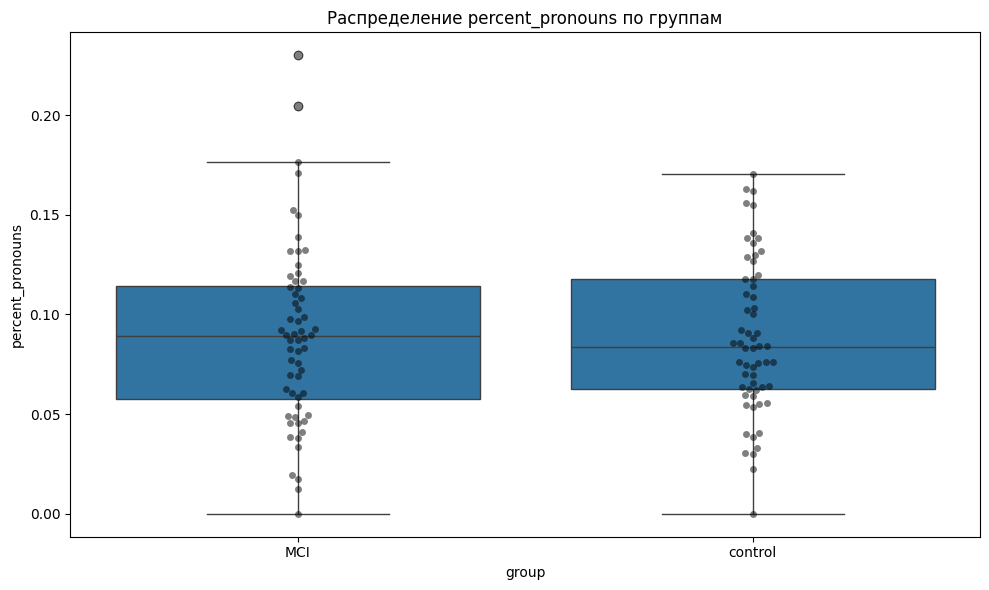

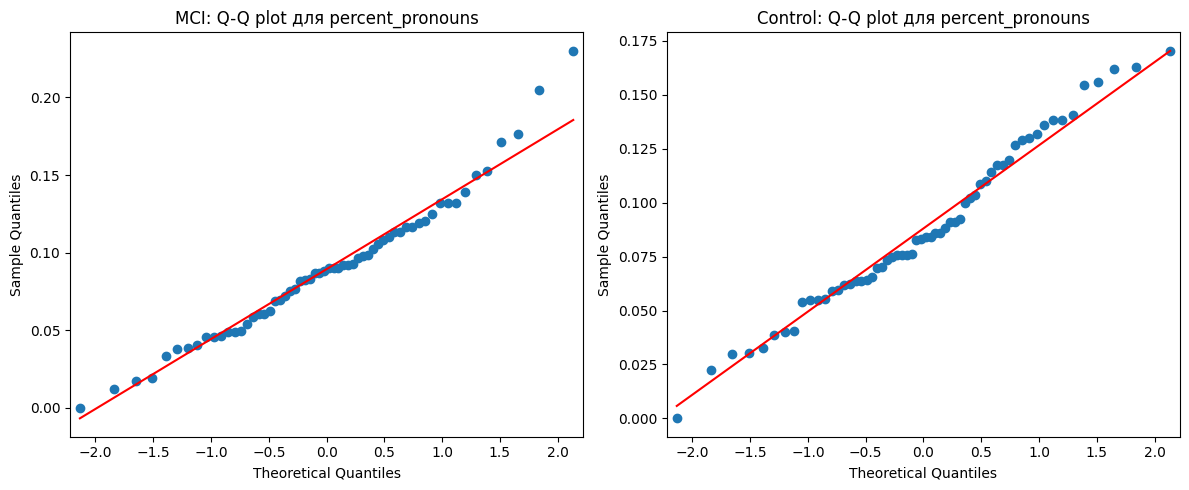

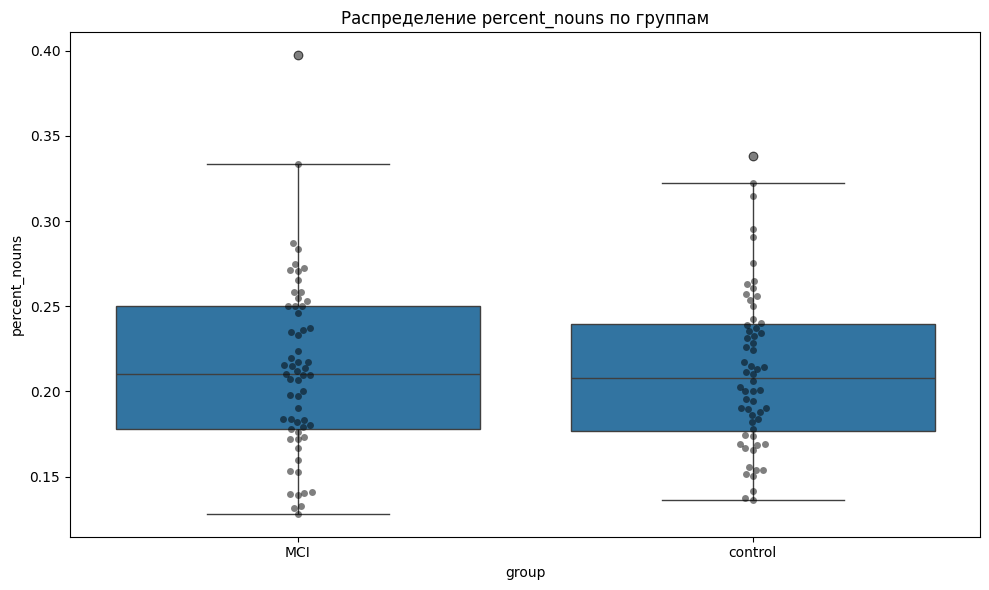

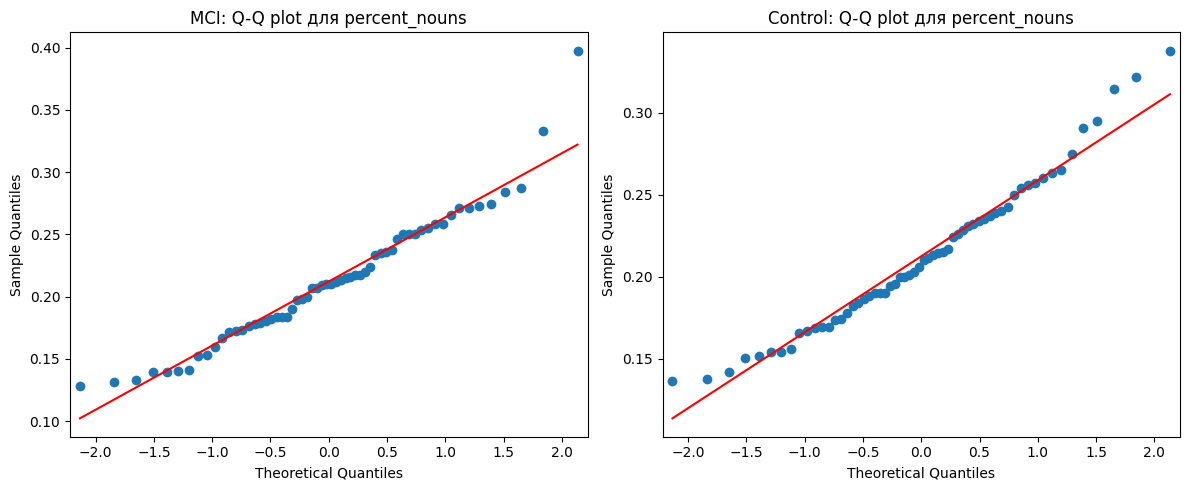

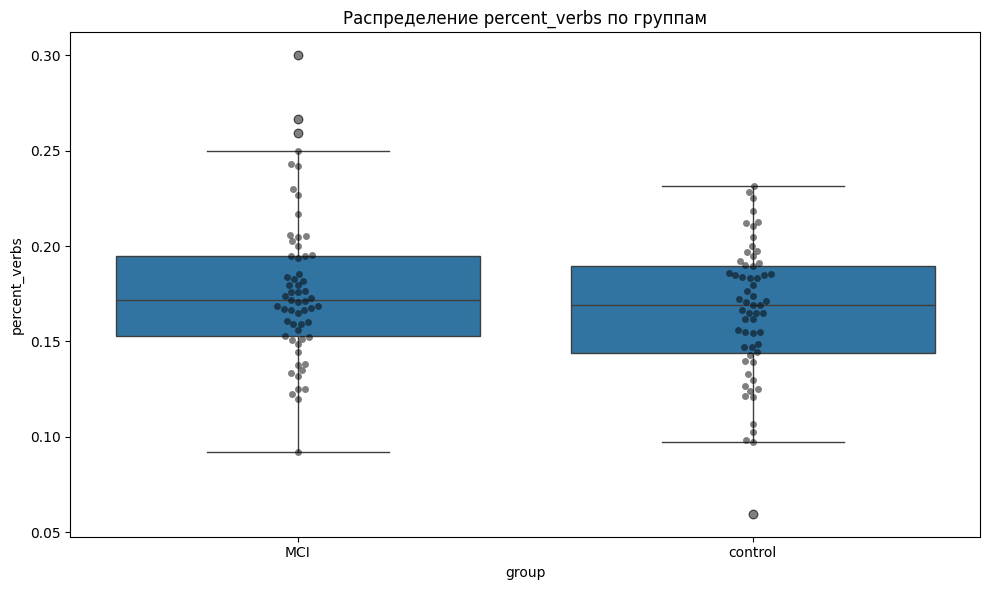

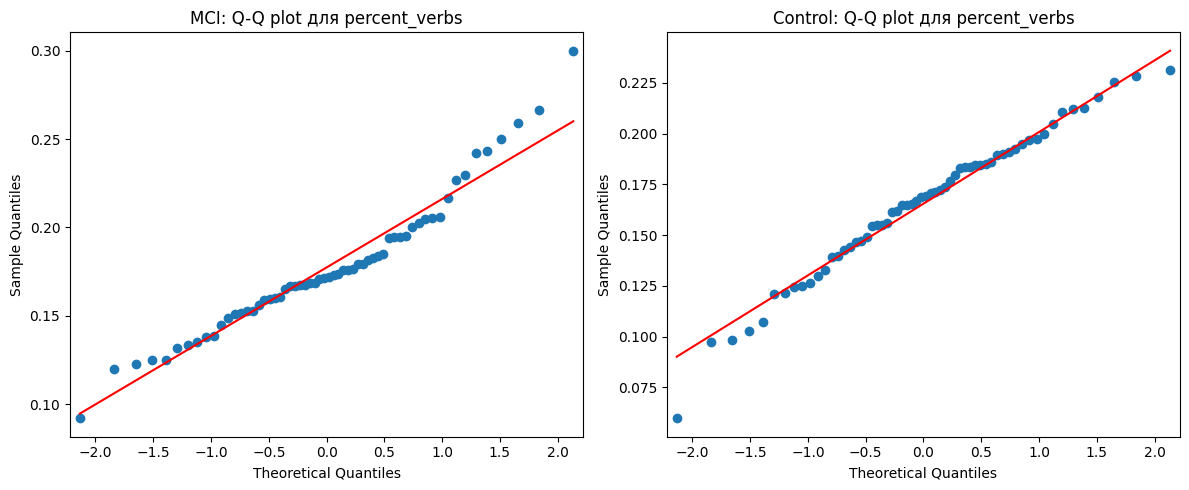

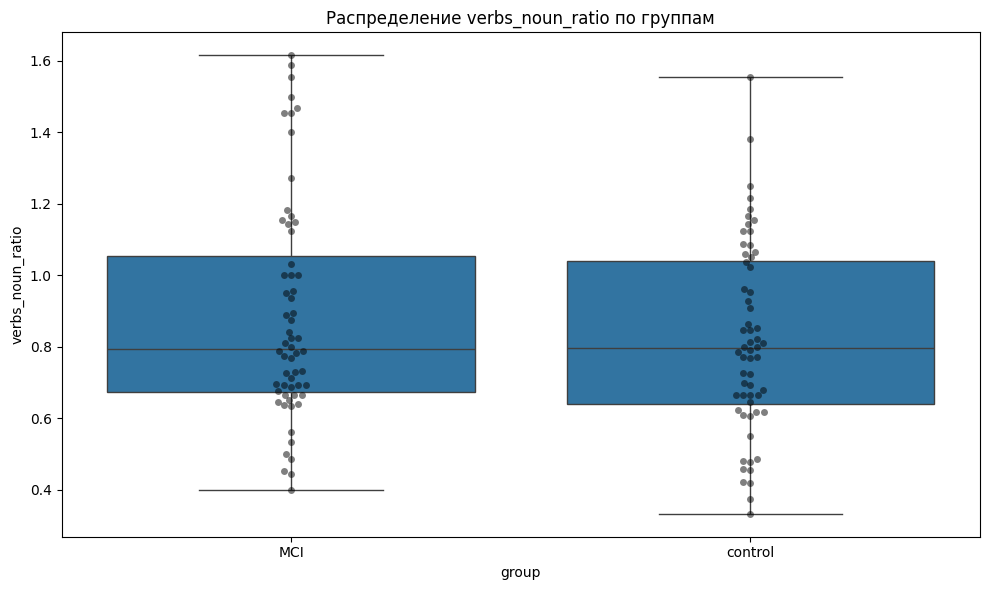

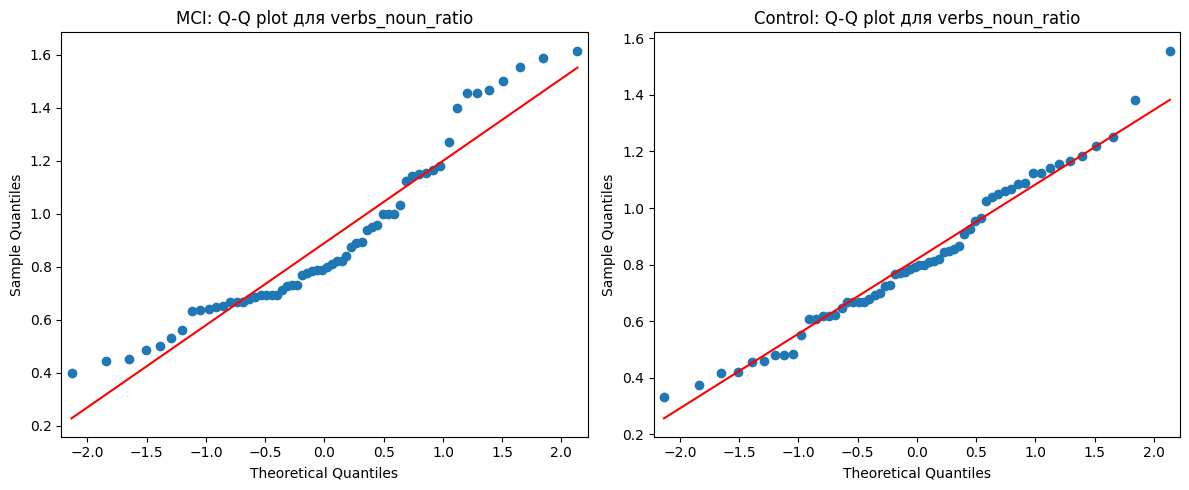

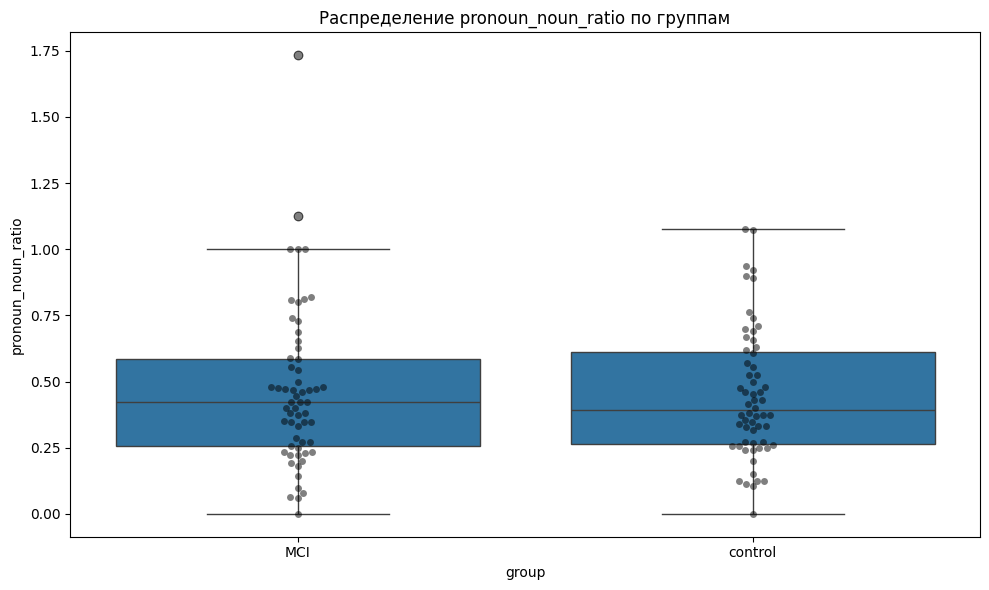

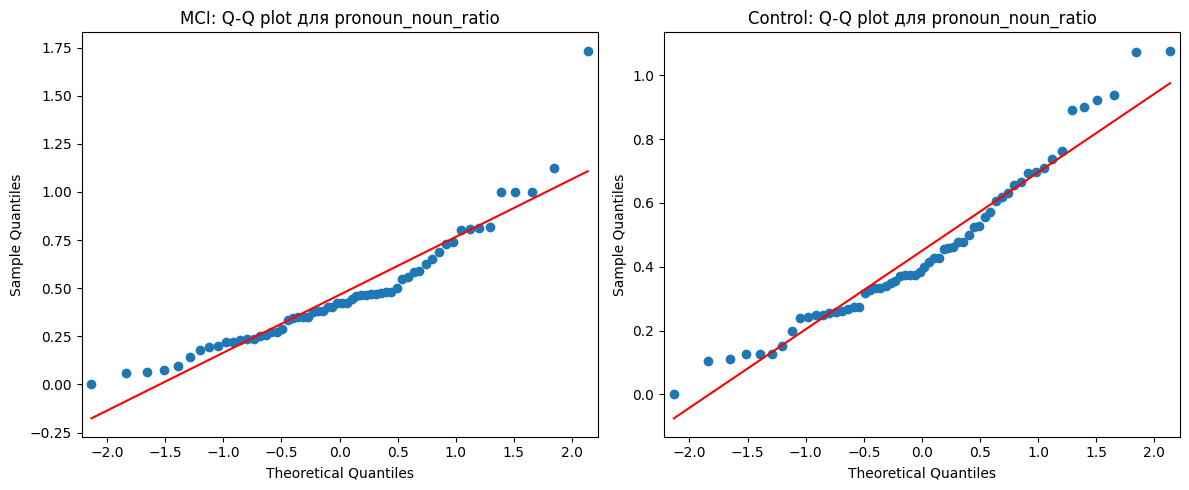

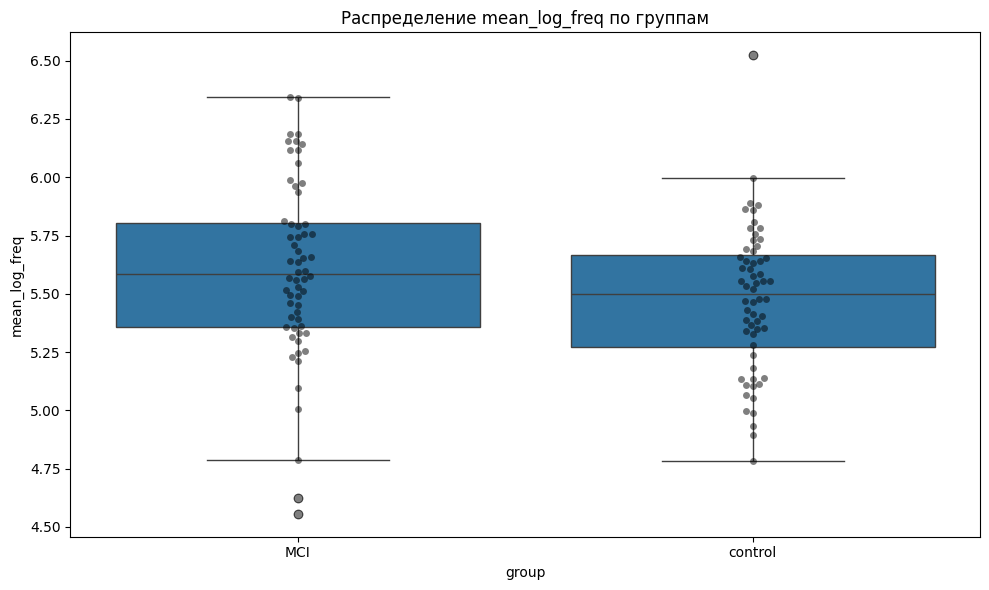

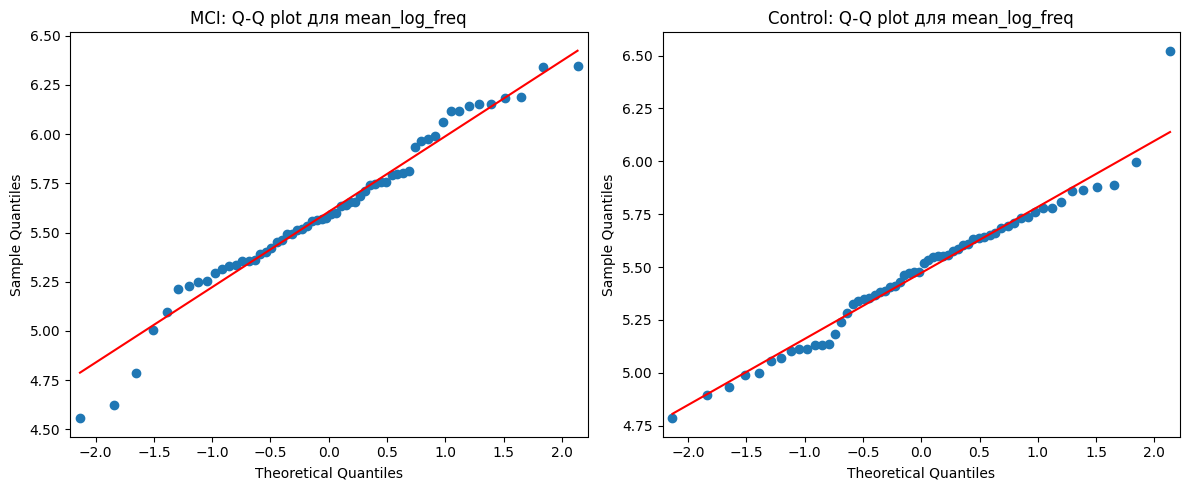


ANOVA анализ:

=== Улучшенный дисперсионный анализ (ANOVA) ===


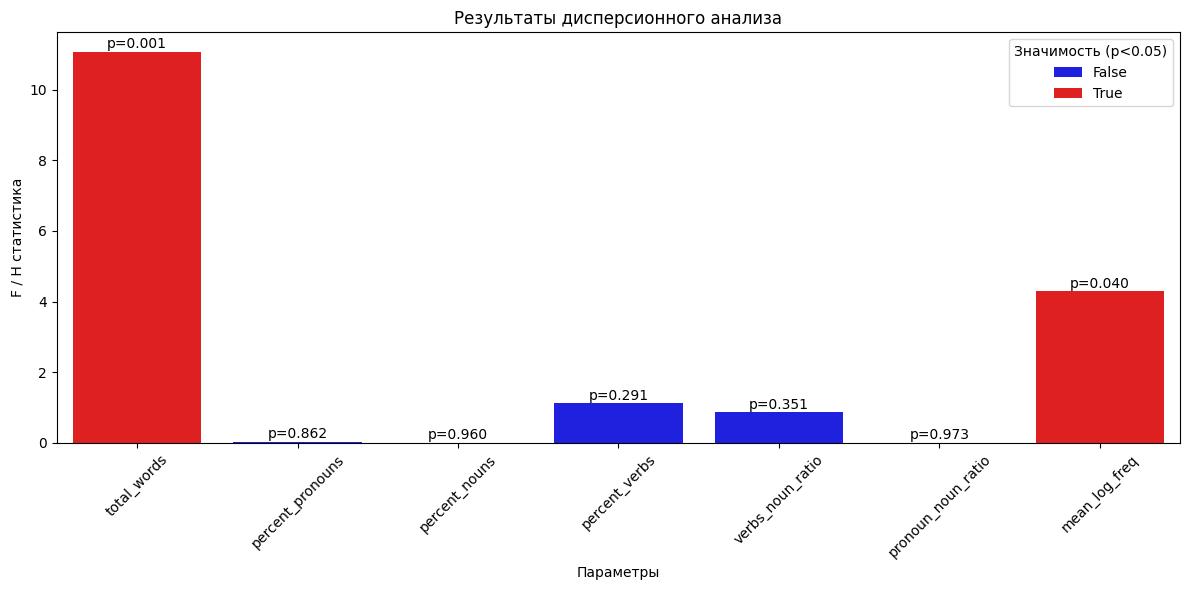


Результаты дисперсионного анализа с размером эффекта:
         Parameter           Test  Statistic  p-value  Significant  Effect Size (eta²)
       total_words Kruskal-Wallis  11.074437 0.000875         True                 NaN
  percent_pronouns          ANOVA   0.030279 0.862156        False            0.000257
     percent_nouns Kruskal-Wallis   0.002486 0.960231        False                 NaN
     percent_verbs Kruskal-Wallis   1.113041 0.291422        False                 NaN
  verbs_noun_ratio Kruskal-Wallis   0.868203 0.351453        False                 NaN
pronoun_noun_ratio Kruskal-Wallis   0.001164 0.972782        False                 NaN
     mean_log_freq          ANOVA   4.292885 0.040451         True            0.035103

Анализ для 60 человек завершен!

Начало анализа для группы из 100 человек

=== Обработка группы MCI ===
Обработан файл: AA1010.cha
Обработан файл: BB5946.cha
Обработан файл: BN9025_T4.cha
Обработан файл: BS8637_T4.cha
Обработан файл: BV2629_T3.cha


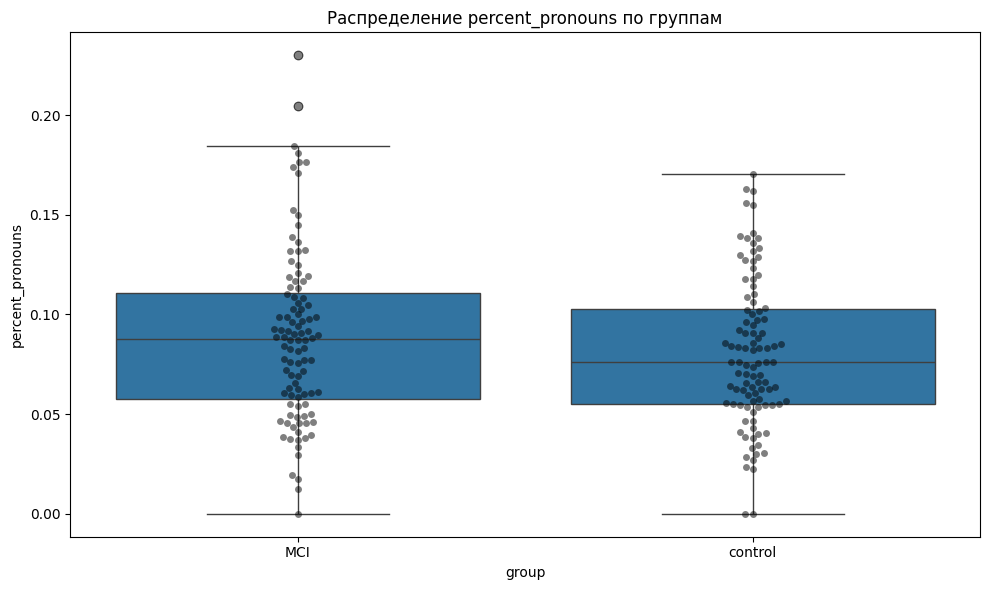

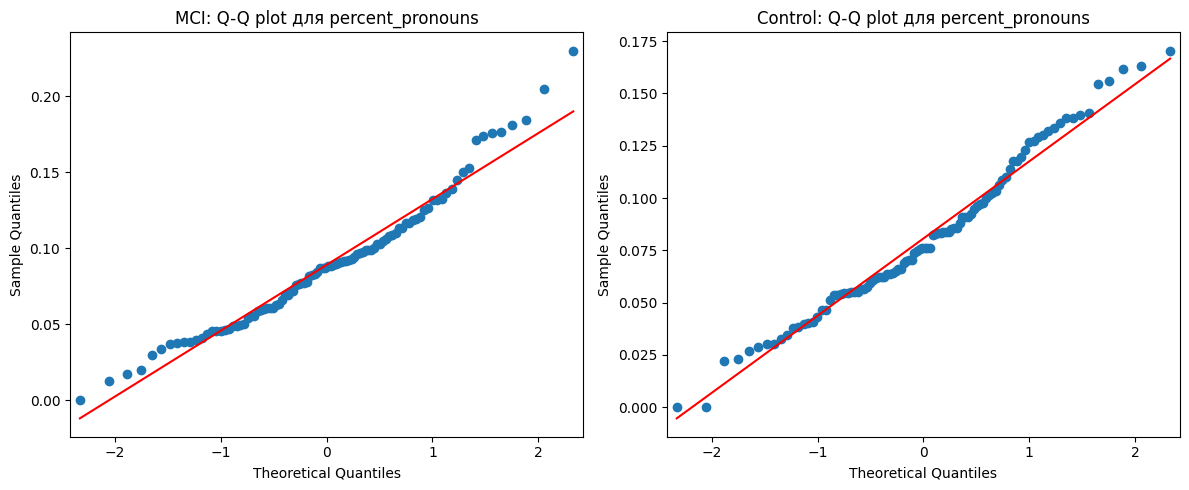

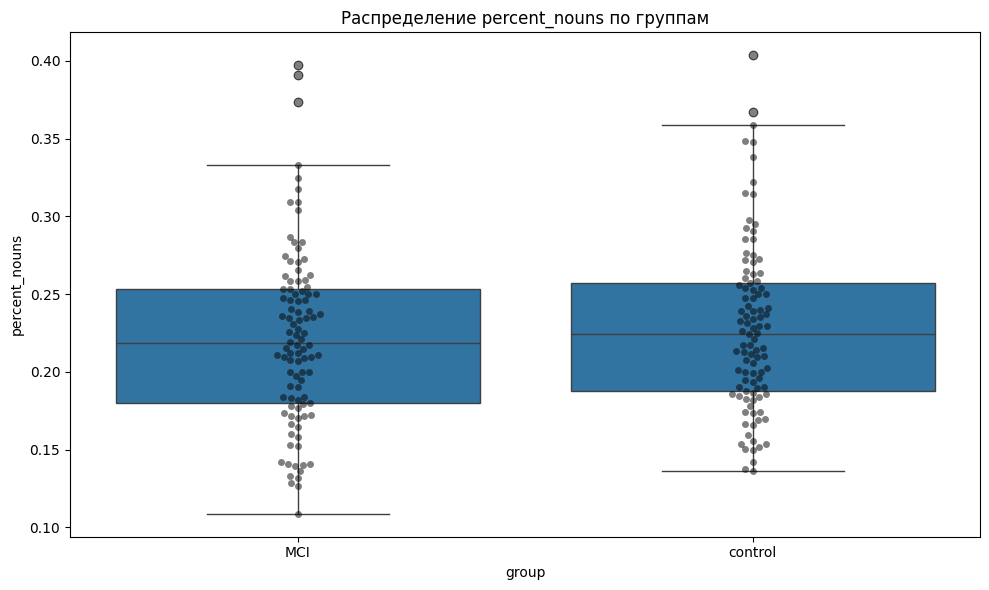

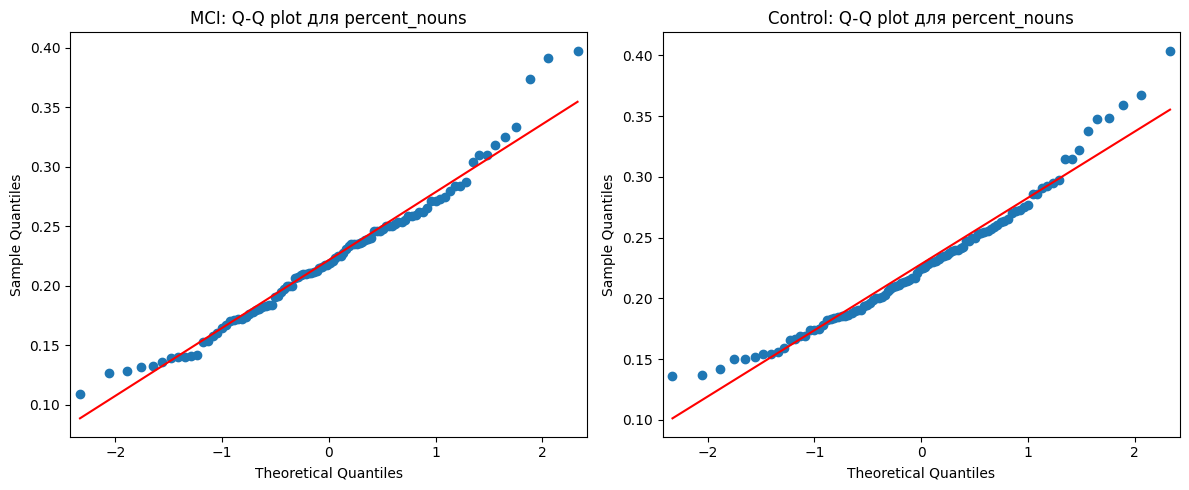

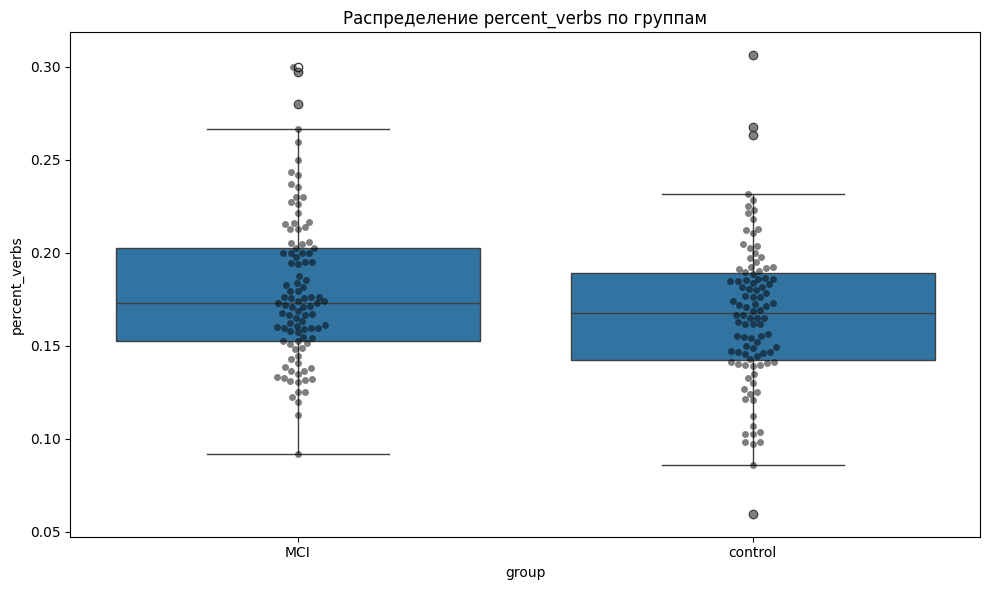

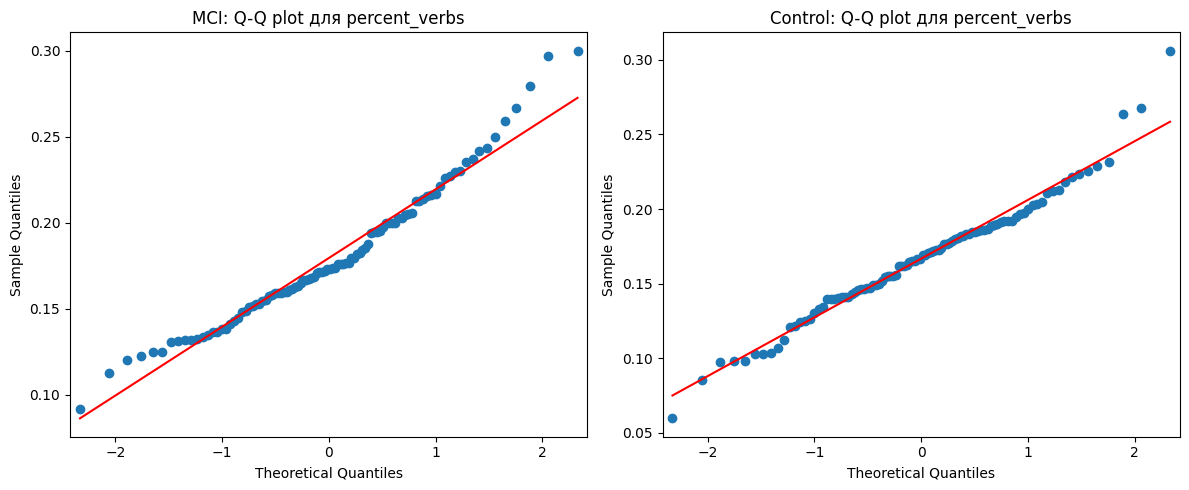

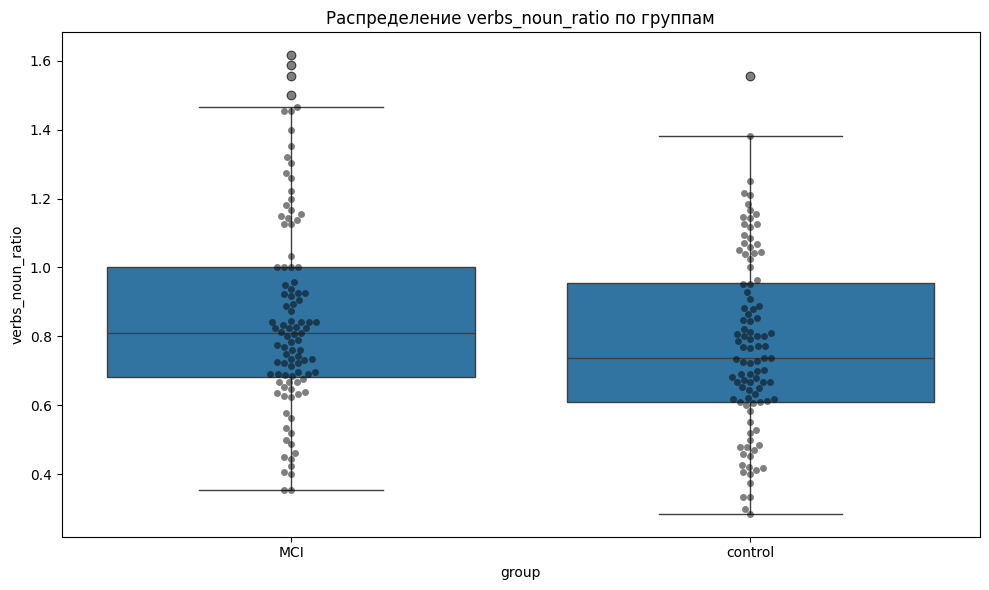

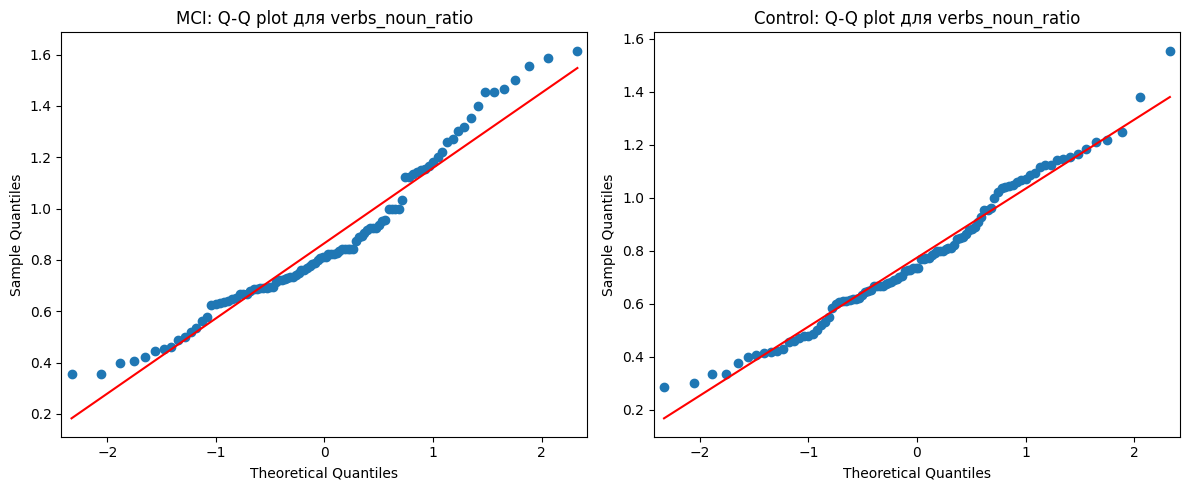

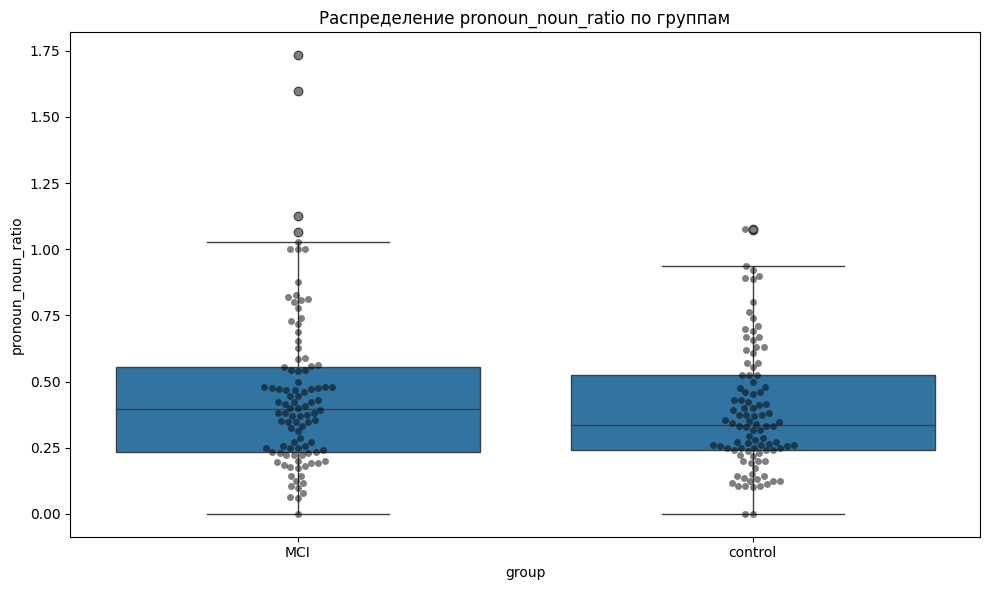

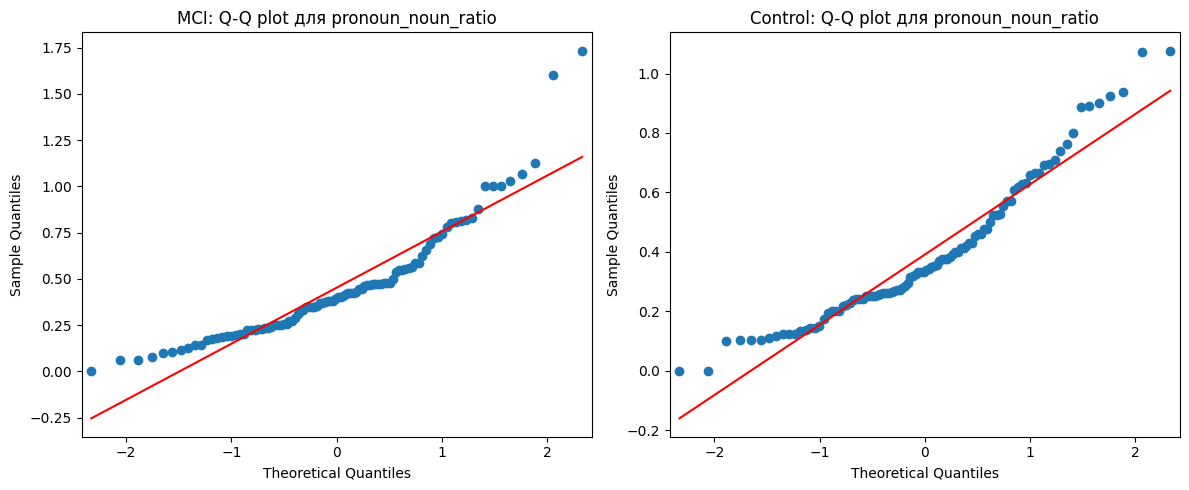

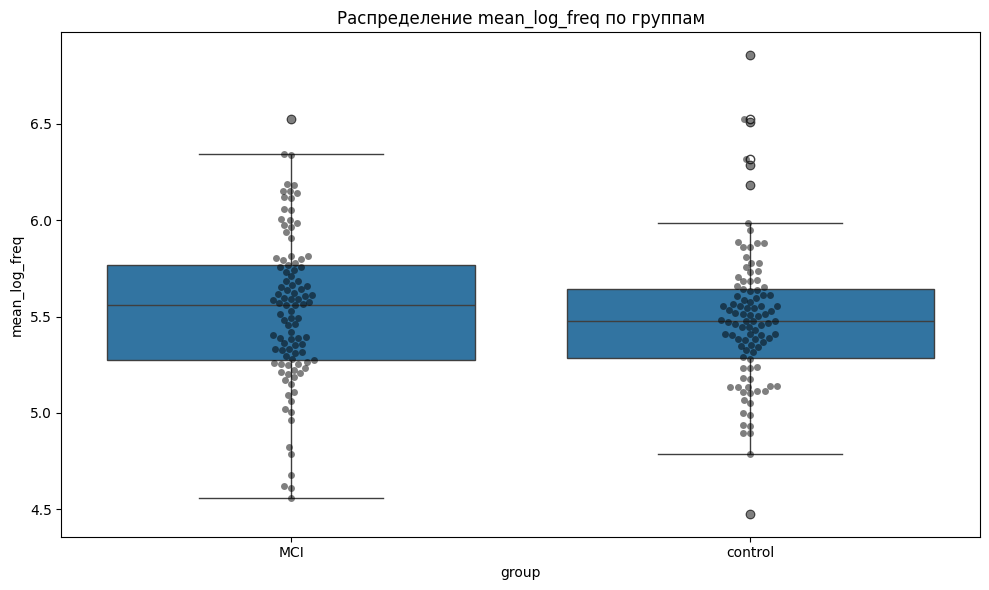

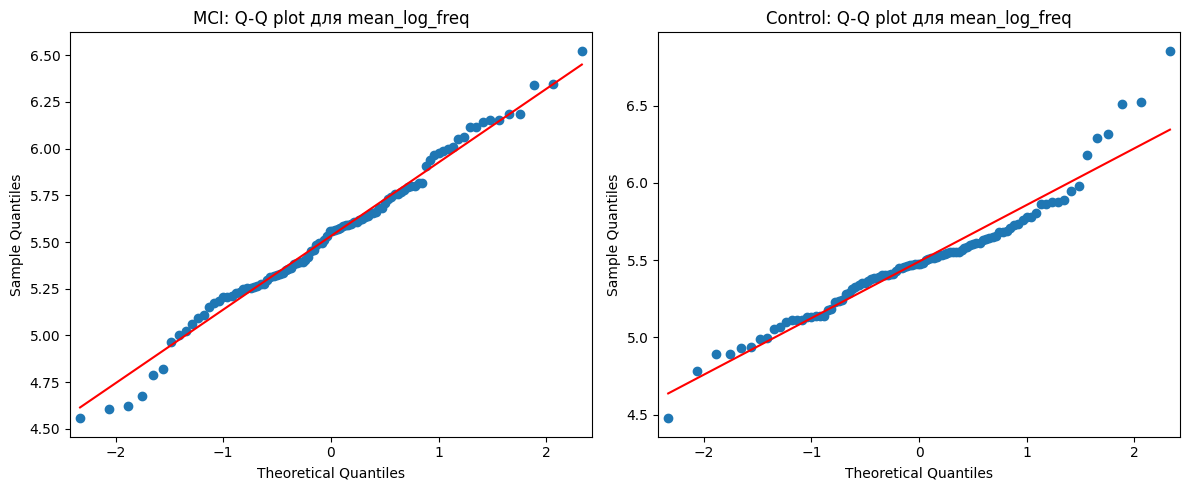


ANOVA анализ:

=== Улучшенный дисперсионный анализ (ANOVA) ===


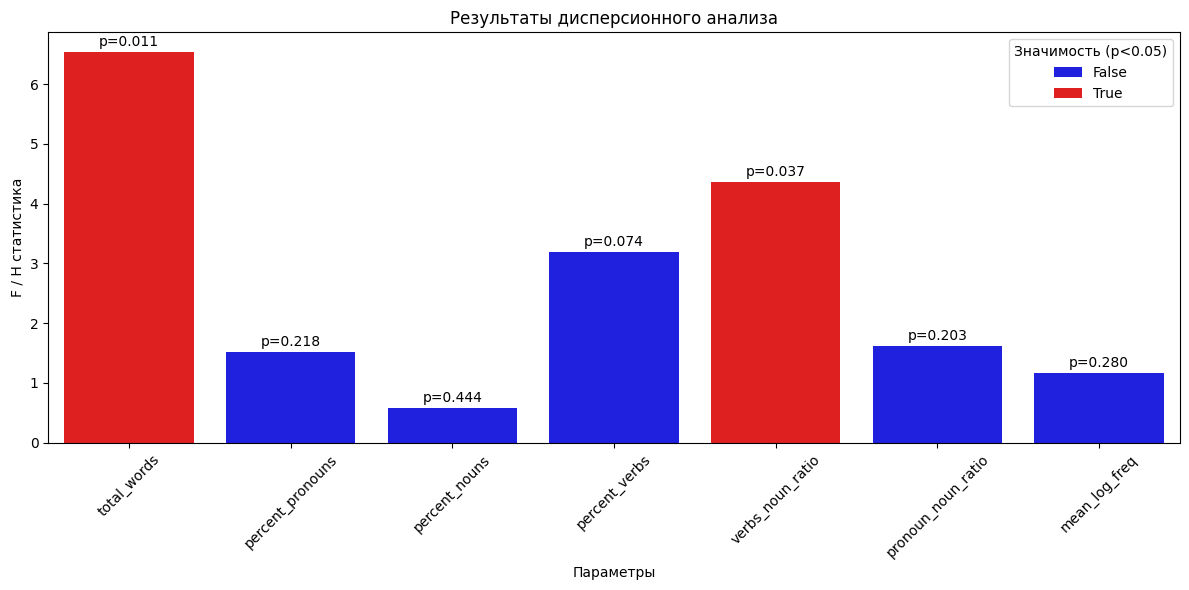


Результаты дисперсионного анализа с размером эффекта:
         Parameter           Test  Statistic  p-value  Significant Effect Size (eta²)
       total_words Kruskal-Wallis   6.538954 0.010554         True               None
  percent_pronouns Kruskal-Wallis   1.516578 0.218138        False               None
     percent_nouns Kruskal-Wallis   0.586784 0.443665        False               None
     percent_verbs Kruskal-Wallis   3.194741 0.073875        False               None
  verbs_noun_ratio Kruskal-Wallis   4.354592 0.036909         True               None
pronoun_noun_ratio Kruskal-Wallis   1.620773 0.202984        False               None
     mean_log_freq Kruskal-Wallis   1.166352 0.280152        False               None

Анализ для 100 человек завершен!


In [138]:
if __name__ == "__main__":
    # Анализ для 60 человек
    run_analysis(
        mci_folder='MCI - данные',
        control_folder='Контроль-группа данные',
        group_size="60"
    )
    
    # Анализ для 100 человек
    run_analysis(
        mci_folder='MCI - данные_100',
        control_folder='Контроль-группа данные_100',
        group_size="100"
    )

In [133]:
text = read_text_file("AA1010.cha")
print(text)

@UTF8
@Window:	0_0_0_0_0_0_158_1_158_1
@Begin
@Languages:	rus
@Participants:	PAR Participant, INV Investigator
@ID:	rus|AA1010|PAR|||||Participant|||
@ID:	rus|AA1010|INV|||||Investigator|||
@Media:	AA1010, audio

*PAR:	ну вот совсем недавно был юбилей моей дочки &*INV:=mhm (0.569) ей
	было пятьдесят лет. 0_7219
*PAR:	мы ходили в кафе. 8060_9349
*PAR:	было много очень друзей (0.534) с работы (0.623) и даже была одна
	 (0.830) &=a девочка молодая (0.911) моя дочка работает
	воспитателем (0.679) ее первая воспитанница. 10451_23749
*PAR:	эта первая воспитанница (0.912) сашенька она <вела этот> [///] была
	как &=inhales +... 24799_31158
*INV:	ведущая? 31942_32383
*PAR:	да ведущая этого нашего праздника (1.214) и она &=a значит (0.789)
	в конце сказала что (1.370) я так рада что моя первая
	воспитательница моя <учи> [/] учительница была вот оксана
	олеговна.   32719_47937
*PAR:	и (0.559) нам как родителям было очень приятно мы просто сидели и
	балдели потому что (0.517) это очень

In [134]:
cleaned_text = clean_cha_text(text)
print("\nТекст после удаления строк интервьюера:")
print(cleaned_text)


Текст после удаления строк интервьюера:
@UTF8
@Window:	0_0_0_0_0_0_158_1_158_1
@Begin
@Languages:	rus
@Participants:	PAR Participant, INV Investigator
@ID:	rus|AA1010|PAR|||||Participant|||
@ID:	rus|AA1010|INV|||||Investigator|||
@Media:	AA1010, audio

*PAR:	ну вот совсем недавно был юбилей моей дочки &*INV:=mhm (0.569) ей
	было пятьдесят лет. 0_7219
*PAR:	мы ходили в кафе. 8060_9349
*PAR:	было много очень друзей (0.534) с работы (0.623) и даже была одна
	 (0.830) &=a девочка молодая (0.911) моя дочка работает
	воспитателем (0.679) ее первая воспитанница. 10451_23749
*PAR:	эта первая воспитанница (0.912) сашенька она <вела этот> [///] была
	как &=inhales +... 24799_31158
*PAR:	да ведущая этого нашего праздника (1.214) и она &=a значит (0.789)
	в конце сказала что (1.370) я так рада что моя первая
	воспитательница моя <учи> [/] учительница была вот оксана
	олеговна.   32719_47937
*PAR:	и (0.559) нам как родителям было очень приятно мы просто сидели и
	балдели потому что (0.51

In [135]:
lemmas, words = lemmatize_text(text)
print(lemmas)

['ну', 'вот', 'совсем', 'недавно', 'быть', 'юбилей', 'мой', 'дочка', 'она', 'быть', 'пятьдесят', 'год', 'мы', 'ходить', 'в', 'кафе', 'быть', 'много', 'очень', 'друг', 'с', 'работа', 'и', 'даже', 'быть', 'один', 'девочка', 'молодой', 'мой', 'дочка', 'работать', 'воспитатель', 'она', 'первый', 'воспитанница', 'этот', 'первый', 'воспитанница', 'сашенька', 'она', 'вести', 'этот', 'быть', 'как', 'да', 'ведущий', 'это', 'наш', 'праздник', 'и', 'она', 'значит', 'в', 'конец', 'сказать', 'что', 'я', 'так', 'рада', 'что', 'мой', 'первый', 'воспитательница', 'мой', 'учить', 'учительница', 'быть', 'вот', 'оксана', 'олегович', 'и', 'мы', 'как', 'родитель', 'быть', 'очень', 'приятно', 'мы', 'просто', 'сидеть', 'и', 'балдеть', 'потому', 'что', 'это', 'очень', 'ценный', 'когда', 'ребёнок', 'который', 'выпускаться', 'до', 'сей', 'пора', 'помнить', 'свой', 'воспитательница']


In [114]:
for word in lemmas:
    parsed = morph.parse(word)[0]
    print(f"{word} → {parsed.tag} (POS: {parsed.tag.POS})")

хороший → ADJF,Qual masc,sing,nomn (POS: ADJF)
подарок → NOUN,inan,masc sing,accs (POS: NOUN)
так → CONJ (POS: CONJ)
сразу → ADVB (POS: ADVB)
и → CONJ (POS: CONJ)
не → PRCL (POS: PRCL)
вспомнить → INFN,perf,tran (POS: INFN)
что → CONJ (POS: CONJ)
я → NPRO,1per sing,nomn (POS: NPRO)
там → ADVB,Dmns (POS: ADVB)
дарить → INFN,impf,tran (POS: INFN)
подарок → NOUN,inan,masc sing,accs (POS: NOUN)
судьба → NOUN,inan,femn sing,nomn (POS: NOUN)
неожиданный → ADJF,Qual masc,sing,nomn (POS: ADJF)
для → PREP (POS: PREP)
я → NPRO,1per sing,nomn (POS: NPRO)
я → NPRO,1per sing,nomn (POS: NPRO)
считать → INFN,perf,tran (POS: INFN)
это → PRCL (POS: PRCL)
поездка → NOUN,inan,femn sing,nomn (POS: NOUN)
вот → PRCL (POS: PRCL)
у → PREP (POS: PREP)
я → NPRO,1per sing,nomn (POS: NPRO)
быть → INFN,impf,intr (POS: INFN)
в → PREP (POS: PREP)
южный → ADJF,Qual masc,sing,nomn (POS: ADJF)
африка → NOUN,inan,femn,Sgtm,Geox sing,nomn (POS: NOUN)
ну → PRCL (POS: PRCL)
она → NPRO,femn,3per,Anph sing,nomn (POS: NPRO)
н

In [115]:
nouns = count_pos(lemmas, 'NOUN') 
verbs = count_pos(lemmas, 'VERB')
pronouns = count_pos(lemmas, 'NPRO') 

print(f"Существительные: {nouns}")  
print(f"Глаголы: {verbs}")          
print(f"Местоимения: {pronouns}")  

Существительные: 9
Глаголы: 9
Местоимения: 9


In [116]:
verb_words = [w for w in lemmas if morph.parse(w)[0].tag.POS in {'VERB', 'INFN'}]
print("Глаголы в тексте:", verb_words)
pronoun_words = [w for w in lemmas if morph.parse(w)[0].tag.POS in {'NPRO'}]
print("Местоимения в тексте:", pronoun_words)
noun_words = [w for w in lemmas if morph.parse(w)[0].tag.POS in {'NOUN'}]
print("Существительные в тексте:", noun_words)

Глаголы в тексте: ['вспомнить', 'дарить', 'считать', 'быть', 'случиться', 'подарить', 'снизойти', 'смочь', 'побывать']
Местоимения в тексте: ['я', 'я', 'я', 'я', 'она', 'я', 'я', 'я', 'я']
Существительные в тексте: ['подарок', 'подарок', 'судьба', 'поездка', 'африка', 'подарок', 'мера', 'рада', 'африка']


In [117]:
total_words = len(lemmas)
ratios = calculate_ratios(pronouns, verbs, nouns, total_words)
print("\nЛексические соотношения:")
print(total_words)
for k, v in ratios.items():
    print(f"{k}: {v:.3f}")


Лексические соотношения:
59
pronouns: 9.000
verbs: 9.000
nouns: 9.000
percent_pronouns: 0.153
percent_verbs: 0.153
percent_nouns: 0.153
pronoun_noun_ratio: 1.000
verbs_noun_ratio: 1.000


In [55]:
freq_metrics = calculate_frequency_metrics(lemmas)
print("\nЧастотные характеристики:")
print(f"Средняя логарифмическая частота: {freq_metrics['mean_log_freq']:.3f}")


Частотные характеристики:
Средняя логарифмическая частота: 5.743


In [3]:
text = read_text_file("BZ2902.cha")
print(text)

@UTF8
@Window:	0_0_0_0_1222_1_1563_2_1563_2
@Begin
@Languages:	rus
@Participants:	PAR Participant, INV Investigator

@ID:	rus|BZ2902|PAR|||||Participant|||
@ID:	rus|BZ2902|INV|||||Investigator|||
@Media:	BZ2902, audio
*INV:	ну рассказывайте. 0_824
*PAR:	на мое &+шести шестидесятилетие &-ah (1.347) мой племянник подарил
	нам с мужем (0.488) поездку в Сочи.  824_10286
*PAR:	заказал отель &-eh (0.481) номер. 10659_12714
*PAR:	и (0.731) &-uh (0.859) ну <все> [/] все было очень хорошо. 12756_16146
*PAR:	и (0.724) &-ah (0.259) гостиница была прямо на берегу Черного моря. 16204_19756
*PAR:	это был март. 20193_21517
*PAR:	погода была прекрасная солнечная. 21761_24129
*PAR:	мы отдыхали гуляли &-ah_uh (4.598) брали экскурсии. 24632_33537
*PAR:	&-ну (0.668) в общем нам очень понравилось и настроение было на
	позитиве. 34478_38750
*PAR:	ну &+по погода иногда менялась &-но (1.114) это не портило вообще
	наше настроение было очень здорово. 39586_45344
*PAR:	и я им до сих пор очен

In [6]:
cleaned_text = clean_cha_text(text)
print("\nТекст после удаления строк интервьюера:")
print(cleaned_text)


Текст после удаления строк интервьюера:
@UTF8
@Window:	0_0_0_0_1222_1_1563_2_1563_2
@Begin
@Languages:	rus
@Participants:	PAR Participant, INV Investigator

@ID:	rus|BZ2902|PAR|||||Participant|||
@ID:	rus|BZ2902|INV|||||Investigator|||
@Media:	BZ2902, audio
*PAR:	на мое &+шести шестидесятилетие &-ah (1.347) мой племянник подарил
	нам с мужем (0.488) поездку в Сочи.  824_10286
*PAR:	заказал отель &-eh (0.481) номер. 10659_12714
*PAR:	и (0.731) &-uh (0.859) ну <все> [/] все было очень хорошо. 12756_16146
*PAR:	и (0.724) &-ah (0.259) гостиница была прямо на берегу Черного моря. 16204_19756
*PAR:	это был март. 20193_21517
*PAR:	погода была прекрасная солнечная. 21761_24129
*PAR:	мы отдыхали гуляли &-ah_uh (4.598) брали экскурсии. 24632_33537
*PAR:	&-ну (0.668) в общем нам очень понравилось и настроение было на
	позитиве. 34478_38750
*PAR:	ну &+по погода иногда менялась &-но (1.114) это не портило вообще
	наше настроение было очень здорово. 39586_45344
*PAR:	и я им до сих

In [13]:
lemmas, words = lemmatize_text(text)
print(lemmas)
print(len(lemmas))

['на', 'мой', 'шесть', 'шестидесятилетие', 'мой', 'племянник', 'подарить', 'мы', 'с', 'муж', 'поездка', 'в', 'сочи', 'заказать', 'отель', 'номер', 'и', 'ну', 'всё', 'всё', 'быть', 'очень', 'хорошо', 'и', 'гостиница', 'быть', 'прямо', 'на', 'берег', 'чёрный', 'море', 'это', 'быть', 'март', 'погода', 'быть', 'прекрасный', 'солнечный', 'мы', 'отдыхать', 'гулять', 'брать', 'экскурсия', 'ну', 'в', 'общий', 'мы', 'очень', 'понравиться', 'и', 'настроение', 'быть', 'на', 'позитив', 'ну', 'по', 'погода', 'иногда', 'меняться', 'но', 'это', 'не', 'портить', 'вообще', 'наш', 'настроение', 'быть', 'очень', 'здорово', 'и', 'я', 'они', 'до', 'сей', 'пора', 'очень', 'благодарный', 'а', 'мы', 'там', 'быть', 'гдеть', 'пять', 'день', 'мы', 'там', 'быть', 'да', 'да', 'да', 'ну', 'просто', 'у', 'мы', 'ребёнок', 'с', 'муж', 'нет', 'а', 'мой', 'племянник', 'я', 'как', 'бы', 'с', 'они', 'очень', 'дружить', 'прям', 'я', 'у', 'они', 'там', 'вера', 'муж', 'иногда', 'ревновать', 'и', 'мы', 'дружить', 'и', 'они', 